<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Simplified/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm

#!pip install tqdm==4.66.1

#function for importing dataframes from MyDrive
def import_variable(file_name):
  load_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}"

  try:
      variable = pd.read_parquet(load_path)

      print(f"Successfully loaded data from {load_path}")

  except FileNotFoundError:
      print(f"Error: The file was not found at {load_path}")
  except Exception as e:
      print(f"An error occurred while loading the file: {e}")
  return variable

# #run this funciton with this line
# x = import_variable("testing2_2025-05-22 19:07:29.595379.parquet")

# Correlation Code

## Function: Download Raw Stock Data to My Drive

In [2]:
# Run this if I need to download historical data and save it to MyDrive
def DownloadStockData():
  #Download the stock data
  !if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  #move the stock data to my Drive
  !mv usa_stocks_30m.parquet "/content/drive/MyDrive/Colab Notebooks"
# DownloadStockData()

# Run this if I have already downloaded the hisotrical data and need to import
# Historical data from MyDrive
def ImportStockData():
  # Import the stock data from My Drive
  # Define nasdaq_stocks as the stock data
  # Specify the full path to the file in your Google Drive
  nasdaq_stocks = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/usa_stocks_30m.parquet")
  return nasdaq_stocks
nasdaq_stocks = ImportStockData()


# Manipulate the historical data for correlation function
def ManipulateStockData(nasdaq_stocks):
  #add year, month, and day columns
  #df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
  nasdaq_stocks["year"] = nasdaq_stocks.datetime.dt.year
  nasdaq_stocks["month"] = nasdaq_stocks.datetime.dt.month
  nasdaq_stocks["day"] = nasdaq_stocks.datetime.dt.day

  # #Filter the DataFrame based on the 'year' column
  # stock_TimeFiltered = nasdaq_stocks.loc[nasdaq_stocks['year'] >= 2023]

  #stock_TimeFiltered.info()
  #stock_TimeFiltered.head()

  #aggregate data by ticker, month, day, closing cost.
  stock_TimeFiltered_aggregated_close = nasdaq_stocks.groupby(["ticker", "year", "month", "day"]).agg({"close": "last"})

  #stock_TimeFiltered_aggregated_close.info()
  #stock_TimeFiltered_aggregated_close.head()
  return stock_TimeFiltered_aggregated_close

stock_TimeFiltered_aggregated_close = ManipulateStockData(nasdaq_stocks)

In [33]:
# prompt: I want to filter stock_TimeFiltered_aggregated_close To only show data for AAPL

aapl_data = stock_TimeFiltered_aggregated_close.loc['AAPL']

In [24]:
aapl_data.info()
print('--------')
print(aapl_data.head(1))
print('--------')
print(aapl_data.tail(1))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6639 entries, (np.int32(1998), np.int32(1), np.int32(2)) to (np.int32(2024), np.int32(3), np.int32(13))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   6639 non-null   float64
dtypes: float64(1)
memory usage: 71.7 KB
--------
                close
year month day       
1998 1     2     0.14
--------
                 close
year month day        
2024 3     13   171.12


In [31]:
  # Convert end_date to datetime object
  end_date = '2023-12-31'
  range_months = 6

   # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months = range_months)

    # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  aapl_data['datetime'] = pd.to_datetime(aapl_data.index.get_level_values('year').astype(str) + '-' +
                                   aapl_data.index.get_level_values('month').astype(str) + '-' +
                                   aapl_data.index.get_level_values('day').astype(str))
  filtered_df = aapl_data[(aapl_data['datetime'] >= start_datetime) & (aapl_data['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column

In [32]:
print(f'The end date is {end_datetime}')
print(f'The end date is {start_datetime}')
print('--------')
filtered_df.info()
print('--------')
print(filtered_df.head(1))
print('--------')
print(filtered_df.tail(1))

The end date is 2023-12-31 00:00:00
The end date is 2023-06-30 00:00:00
--------
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (np.int32(2023), np.int32(6), np.int32(30)) to (np.int32(2023), np.int32(12), np.int32(30))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   135 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB
--------
                close
year month day       
2023 6     30   193.8
--------
                close
year month day       
2023 12    30   192.5


## Function: Correlation Coeficient for entire stock data set

In [4]:
def calculate_lagged_correlation(df, end_date, lag_days=1, range_months=6):
  # import pandas as pd
  # import numpy as np
  # from tqdm.notebook import tqdm # Import tqdm
  """
  Calculates the pairwise Pearson correlation coefficient between all stocks
  in a DataFrame for a specified 6-month period with a given lag.

  Args:
    df: DataFrame with a MultiIndex (ticker, year, month, day) and 'close' column.
    end_date: The end date (inclusive) of the 6-month period as a string 'YYYY-MM-DD'.
    lag_days: The number of days to lag the second stock's data.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months = range_months)

  # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  df['datetime'] = pd.to_datetime(df.index.get_level_values('year').astype(str) + '-' +
                                   df.index.get_level_values('month').astype(str) + '-' +
                                   df.index.get_level_values('day').astype(str))
  filtered_df = df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column


  # Get unique tickers in the filtered data
  tickers = filtered_df.index.get_level_values('ticker').unique()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker
    stock_a_data = filtered_df.loc[ticker_a, 'close']

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker
        stock_b_data = filtered_df.loc[ticker_b, 'close']

        # Align the dataframes based on the date index
        aligned_data = pd.merge(stock_a_data.reset_index(), stock_b_data.reset_index(),
                                on=['year', 'month', 'day'], how='inner', suffixes=('_A', '_B'))
        aligned_data['datetime'] = pd.to_datetime(aligned_data['year'].astype(str) + '-' +
                                                  aligned_data['month'].astype(str) + '-' +
                                                  aligned_data['day'].astype(str))
        aligned_data = aligned_data.set_index('datetime').sort_index()

        # Apply the lag to stock_b_data
        lagged_stock_b_data = aligned_data['close_B'].shift(lag_days)

        # #Calculate correlation, dropping NaN values
        # correlation = aligned_data['close_A'].corr(lagged_stock_b_data)

        correlation = aligned_data['close_A'].corr(lagged_stock_b_data, method='spearman', min_periods=100)

        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# enter end date and run correlation function on entire stock data. This will take a couple of hours
end_date = '2023-12-31'
spearman_lagged_correlations = calculate_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

Calculating correlations:   0%|          | 0/510 [00:00<?, ?it/s]

## Function: Export variables to My Drive

In [5]:
# Export a panda dataframe to MyDrive
def export_variable(variable_name, file_name):

  now = datetime.datetime.now()

  save_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}_{now}.parquet"

  try:
      variable_name.to_parquet(save_path)
      print(f"Successfully saved the variable to {save_path}")
  except Exception as e:
      print(f"An error occurred while saving the file: {e}")
  return

export_variable(spearman_lagged_correlations, "spearman_lagged_correlations")

Successfully saved the variable to /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet


# Import Correlated Data from MyDrive

In [ ]:
# #import correlation data from entire stock data that I saved off earlier on MyDrive
pearson_sixMonth_correlation_data = import_variable("6month_correlation_data.parquet")
spearman_sixMonth_correlation_data = import_variable("spearman_lagged_correlations_2025-06-03 18:13:09.551585.parquet")





Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/6month_correlation_data.parquet
Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/spearman_lagged_correlations_2025-06-03 15:04:22.502301.parquet


In [7]:
spearman_sixMonth_correlation_data = spearman_lagged_correlations
spearman_sixMonth_correlation_data.head()

ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZS,ZTS
ticker,,,,,,,,,,,,,,,,,,,,,
A,NaN,0.571778,0.768587,0.264335,0.615379,0.843238,-0.510205,0.705266,0.328549,0.854583,...,0.551334,-0.576550,0.413110,0.831392,0.610124,0.578413,0.612757,0.718177,0.289371,0.740271
AAL,0.604758,NaN,0.492223,0.058670,0.653669,0.848553,-0.737696,0.164812,-0.391226,0.744587,...,0.444819,-0.157351,0.908748,0.729978,0.875262,0.917232,0.913948,0.235064,-0.447777,0.454685
AAPL,0.733585,0.450308,NaN,-0.093003,0.511693,0.708667,-0.268324,0.722784,0.438359,0.811337,...,0.755071,-0.798746,0.223611,0.859472,0.530160,0.442359,0.510263,0.496963,0.457494,0.440347
ABBV,0.367236,0.113018,-0.003833,NaN,0.444704,0.213531,-0.427103,0.243092,0.047126,0.183354,...,-0.170082,0.165430,0.174489,0.011942,0.010315,0.153536,0.118266,0.656660,0.145951,0.688197
ABNB,0.628754,0.676627,0.584177,0.315470,NaN,0.727045,-0.485862,0.494014,0.012110,0.748228,...,0.418661,-0.180936,0.641092,0.622160,0.596171,0.753024,0.701102,0.551246,0.056195,0.617814


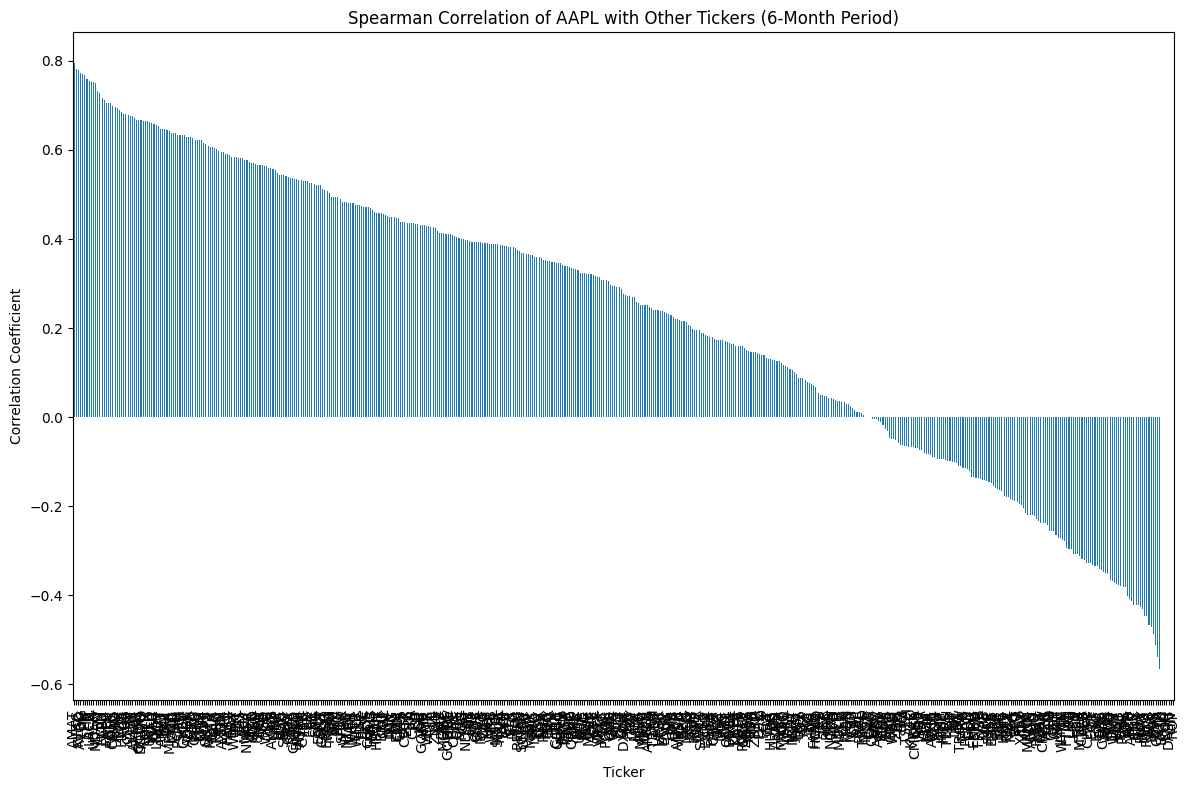

In [22]:
# prompt: From spearman_sixMonth_correlation_data, I want to plot on a graph all of Ticker AAPL correlations in order from greatest correlation to smallest correlation

import matplotlib.pyplot as plt

# Extract the correlations for AAPL
aapl_correlations = spearman_sixMonth_correlation_data.loc['NVDA'].sort_values(ascending=False)

# Remove the correlation of AAPL with itself (which is 1)
aapl_correlations = aapl_correlations.drop('NVDA', errors='ignore')

# Plot the correlations
plt.figure(figsize=(12, 8))
aapl_correlations.plot(kind='bar')
plt.title('Spearman Correlation of AAPL with Other Tickers (6-Month Period)')
plt.xlabel('Ticker')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Process correlated Data

In [28]:
def process_stock_correlations(correlation_df, min_nodes, max_nodes, threshold_percent):
  """
  Processes a DataFrame of stock correlation data by grouping, filtering for
  top correlations, and normalizing values to create 'Orbital Radius' and
  'Planet Radius' columns.

  Args:
    correlation_df: A pandas DataFrame where both index and columns are tickers
                    representing pairwise correlation coefficients.

  Returns:
    A pandas DataFrame with processed correlation data including 'source',
    'target', 'correlation', 'coefficient_of_determination', 'Orbital Radius',
    and 'Planet Radius' columns.
  """
  # Rename the index before stacking to avoid the naming conflict
  correlation_df = correlation_df.rename_axis('ticker_a', axis=0)

  # Use stack to unpivot the correlation matrix into a long format
  # This is more efficient than iterating through index and columns
  grouped_correlation_data = correlation_df.stack().reset_index()

  # Rename the columns appropriately after resetting index
  # The columns after stacking and resetting index will be 'level_0', 'level_1', and 0 by default
  grouped_correlation_data.columns = ['ticker_a', 'ticker_b', 'correlation']


  # Drop self-correlations
  grouped_correlation_data = grouped_correlation_data[grouped_correlation_data['ticker_a'] != grouped_correlation_data['ticker_b']].copy()

  # Calculate the coefficient of determination
  grouped_correlation_data['coefficient_of_determination'] = grouped_correlation_data['correlation']**2

  # Filter for only the top correlations
  # Calculate absolute correlation and group by ticker_a
  grouped_correlation_data['abs_correlation'] = grouped_correlation_data['correlation'].abs()


  # Use a list comprehension to efficiently process each group
  filtered_data_list = []
  for ticker_a, group_df in grouped_correlation_data.groupby('ticker_a'):
      max_abs_correlation = group_df['abs_correlation'].max()
      threshold = max_abs_correlation * threshold_percent

      filtered_group_df_threshold = group_df[group_df['abs_correlation'] >= threshold].copy()

      if len(filtered_group_df_threshold) < min_nodes:
          filtered_group_df = group_df.sort_values(by='abs_correlation', ascending=False).head(min_nodes).copy()
      elif len(filtered_group_df_threshold) > max_nodes:
          filtered_group_df = filtered_group_df_threshold.sort_values(by='abs_correlation', ascending=False).head(max_nodes).copy()
      else:
          filtered_group_df = filtered_group_df_threshold

      filtered_data_list.append(filtered_group_df)


  most_correlated_stocks = pd.concat(filtered_data_list)

  # # Remove the temporary 'abs_correlation' column
  # most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Normalize values for 'Orbital Radius' and 'Planet Radius'
  # Calculate min and max for normalization efficiently using groupby
  min_max_correlations = most_correlated_stocks.groupby('ticker_a')['abs_correlation'].agg(['min', 'max'])
  min_max_coefficient = most_correlated_stocks.groupby('ticker_a')['coefficient_of_determination'].agg(['min', 'max'])

  # Use apply with vectorized operations where possible
  def normalize_row(row, min_max_corr_df, min_max_coeff_df):
      ticker_a = row['ticker_a']
      correlation = row['abs_correlation']
      coefficient = row['coefficient_of_determination']

      min_corr, max_corr = min_max_corr_df.loc[ticker_a, ['min', 'max']]
      min_coeff, max_coeff = min_max_coeff_df.loc[ticker_a, ['min', 'max']]

      # Avoid division by zero if all values for a ticker are the same
      orbital_radius = 0.0 if max_corr == min_corr else 1 - (correlation - min_corr) / (max_corr - min_corr)
      planet_radius = 0.0 if max_coeff == min_coeff else (coefficient - min_coeff) / (max_coeff - min_coeff)


      return pd.Series([orbital_radius, planet_radius], index=['Orbital Radius', 'Planet Radius'])

  # Apply the normalization function
  normalized_values = most_correlated_stocks.apply(
      normalize_row,
      axis=1,
      args=(min_max_correlations, min_max_coefficient)
  )

  most_correlated_stocks[['Orbital Radius', 'Planet Radius']] = normalized_values

  # Remove the temporary 'abs_correlation' column
  most_correlated_stocks = most_correlated_stocks.drop(columns=['abs_correlation'])

  # Reset index and rename columns to the desired long format
  most_correlated_stocks_long = most_correlated_stocks.reset_index(drop=True)
  most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

  return most_correlated_stocks_long

# Example usage with the sixMonth_correlation_data
min_nodes = 3
max_nodes = 15
threshold_percent = 0.95
processed_data = process_stock_correlations(spearman_sixMonth_correlation_data, min_nodes, max_nodes, threshold_percent)
display(processed_data.head())



,source,target,correlation,coefficient_of_determination,Orbital Radius,Planet Radius
0,A,NTRS,0.926960,0.859254,0.000000,1.000000
1,A,BA,0.922795,0.851550,0.105755,0.892193
2,A,BAC,0.917391,0.841606,0.242981,0.753027
3,A,RCL,0.915201,0.837593,0.298599,0.696856
4,A,HBAN,0.915059,0.837333,0.302200,0.693224


In [30]:
sample_processed_data = processed_data[processed_data['source'] == 'AAPL']
display(sample_processed_data)

,source,target,correlation,coefficient_of_determination,Orbital Radius,Planet Radius
26,AAPL,AOS,0.873949,0.763786,0.769665,0.225805
27,AAPL,ASML,0.896774,0.804204,0.265612,0.729404
28,AAPL,C,0.878102,0.771063,0.677945,0.316476
29,AAPL,DDOG,0.871839,0.760103,0.816262,0.179906
30,AAPL,DHI,0.864660,0.747637,0.974778,0.024594
31,AAPL,EQIX,0.886326,0.785574,0.496338,0.497275
32,AAPL,EXPE,0.872392,0.761068,0.804039,0.191935
33,AAPL,LEN,0.875438,0.766391,0.736788,0.258257
34,AAPL,MCO,0.882780,0.779300,0.574648,0.419106
35,AAPL,MPWR,0.908802,0.825922,0.000000,1.000000


# Create Network Diagram

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_ticker_network_visual(correlated_data, source_ticker):
    """
    Plots a network graph for a specific ticker and its most correlated partners,
    where distance is based on 'Orbital Radius', node size on 'Planet Radius',
    and edge labels are correlations as percentages.

    Args:
      correlated_data: DataFrame with columns 'source', 'target', 'correlation',
                       'Orbital Radius', 'Planet Radius'.
      source_ticker: The ticker for which to generate the network graph.
    """
    # Filter the data to include only connections where the target ticker is the source
    ticker_connections = correlated_data[correlated_data['source'] == source_ticker].copy()

    # Handle cases where there are no connections found after filtering
    if ticker_connections.empty:
        print(f"No connections found for ticker {source_ticker} as the source within the provided data.")
        return

    # Create a graph
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    # Customize graph visualization
    plt.figure(figsize=(12, 10))

    # --- Positioning based on 'Orbital Radius' ---
    # We need to create a dictionary of positions where the source_ticker is at the center (0,0)
    # and other nodes are placed based on their 'Orbital Radius'.
    # A simple approach is to place them on a circle with the orbital radius.
    pos = {}
    pos[source_ticker] = (0, 0) # Center the target ticker

    # Place other nodes on a circle based on their orbital radius
    num_connections = len(ticker_connections)
    for i, row in ticker_connections.iterrows():
        target = row['target']
        orbital_radius = row['Orbital Radius']
        # Add the minimum distance to the orbital radius
        min_distance = 0.3
        orbital_radius = orbital_radius + min_distance

        # Distribute nodes around a circle
        angle = 2 * np.pi * i / num_connections
        x = orbital_radius * np.cos(angle)
        y = orbital_radius * np.sin(angle)
        pos[target] = (x, y)

    # --- Node Sizes based on 'Planet Radius' ---
    # Create a dictionary of node sizes
    node_sizes = {}
    node_sizes[source_ticker] = 1000 # Set a fixed size for the central node
    for i, row in ticker_connections.iterrows():
        target = row['target']
        planet_radius = row['Planet Radius']
        # Scale planet radius to a reasonable node size range (e.g., 300 to 800)
        # Assuming 'Planet Radius' is normalized between 0 and 1
        scaled_size = 300 + (planet_radius * 500)
        node_sizes[target] = scaled_size


    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=[node_sizes.get(node, 300) for node in G.nodes()], node_color='skyblue', alpha=0.9)

    # Draw edges and color based on correlation sign
    edge_colors = ['red' if data['correlation'] < 0 else 'green' for u, v, data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

    # Draw labels
    #nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(G, pos, font_size=10)

    # --- Draw edge labels manually at the midpoint of the straight line ---
    edge_labels = {(u, v): data['correlation'] for u, v, data in G.edges(data=True)}
    formatted_edge_labels = {k: f'{v:.2%}' for k, v in edge_labels.items()} # Format as percentage

    for (u, v), label in formatted_edge_labels.items():
        # Get the positions of the connected nodes
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate the midpoint coordinates
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2

        # Draw the text at the midpoint
        plt.text(mid_x, mid_y, label,
                 fontsize=8, color='black', ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f'Network for {source_ticker} and Most Correlated Partners')
    plt.axis('off') # Hide axes
    plt.show()

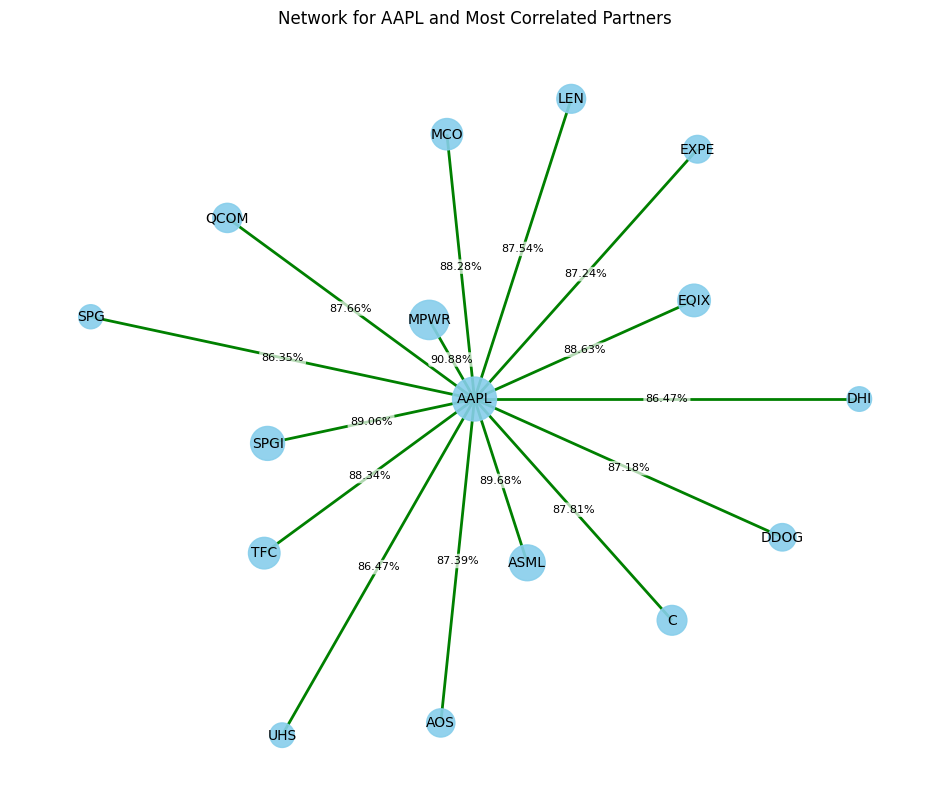

In [31]:
# Example usage:
plot_ticker_network_visual(processed_data, 'AAPL') # Replace 'AAPL' with the ticker you want to visualize